In [20]:
from torchvision.models import vit_b_16
import torch.nn as nn
import torch

from surgeon_pytorch import Extract, get_nodes

from PIL import Image
import torchvision.transforms as transforms
import os

import numpy as np

from matplotlib import pyplot as plt
import cv2

from captum.attr import LayerGradCam, LayerAttribution

In [21]:
model = vit_b_16()
model.heads.head = nn.Linear(768,2)
model.load_state_dict(torch.load("logs/vit_waterbirds.pth",map_location=torch.device('cpu'),weights_only=False))

<All keys matched successfully>

In [22]:
encoder_layers = model.encoder.layers
last_encoder_layer = encoder_layers[-1]
print(last_encoder_layer.self_attention)

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)


In [23]:
from last_encoder_layer import LastEncoderLayer 

my_encoder_layer = LastEncoderLayer(last_encoder_layer)


In [24]:
model.encoder.layers[-1].ln_1

LayerNorm((768,), eps=1e-06, elementwise_affine=True)

In [25]:
my_encoder_layer.eval()
last_encoder_layer.eval()
encoder_layers[-1] = my_encoder_layer

In [26]:
x = torch.rand(100,197,768)

with torch.no_grad():
    original_output = last_encoder_layer(x)
    
with torch.no_grad():
    new_output = my_encoder_layer(x)

In [27]:
torch.abs(original_output - new_output).sum()

tensor(0.6954)

In [28]:
model.encoder.layers[-1].self_attention.need_weights = True

In [29]:
dummy = torch.rand(5,3,224,224)
with torch.no_grad():
    _ = model(dummy)
    
attn_w = model.encoder.layers[-1].attn_weights
print(f"Collected attention weights: {attn_w.shape}")

Collected attention weights: torch.Size([5, 12, 197, 197])


In [30]:
attn_w[4,0].sum()

tensor(197.0000)

In [31]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def tensorize(img_path):
    image = Image.open(img_path).convert('RGB')
    return preprocess(image).unsqueeze(0)

In [32]:
img = tensorize('notebooks/data/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg')[0,:,:,:]
img.shape

torch.Size([3, 224, 224])

In [33]:
a = model(img.unsqueeze(0))
print(a)
a_attn_w = model.encoder.layers[-1].attn_weights
print(a_attn_w.shape)
a_attn_w = a_attn_w[0,:,:,:]

tensor([[ 1.6303, -1.1000]], grad_fn=<AddmmBackward0>)
torch.Size([1, 12, 197, 197])


In [34]:
def visualize_heatmaps(image, attn_weights, figsize=(20, 15)):
    _, axs = plt.subplots(3, 4, figsize=figsize)
    axs = axs.flatten()

    image = image.cpu().numpy() * 0.5 + 0.5
    image = cv2.normalize(image, image, 0, 1, cv2.NORM_MINMAX)
    print(image.min().item(),image.max().item())
    image = image.transpose(1, 2, 0)
    image = np.clip(image, 0, 1)

    for i in range(12):
        # also plot the image
        attn = attn_weights[i,0,1:] # attention paid by cls to other patches
        attn = attn.reshape(14, 14)
        attn = attn.detach().cpu().numpy()
        attn = cv2.resize(attn, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        attn = attn / attn.max()
        
        ax = axs[i]

        ax.imshow(image, alpha=1)
        ax.imshow(attn, cmap='jet', alpha=0.65)
        ax.axis('off')
        ax.set_title(f'Head {i + 1}')

    # plt.tight_layout()
    plt.show()

6.923361439703513e-09 1.0


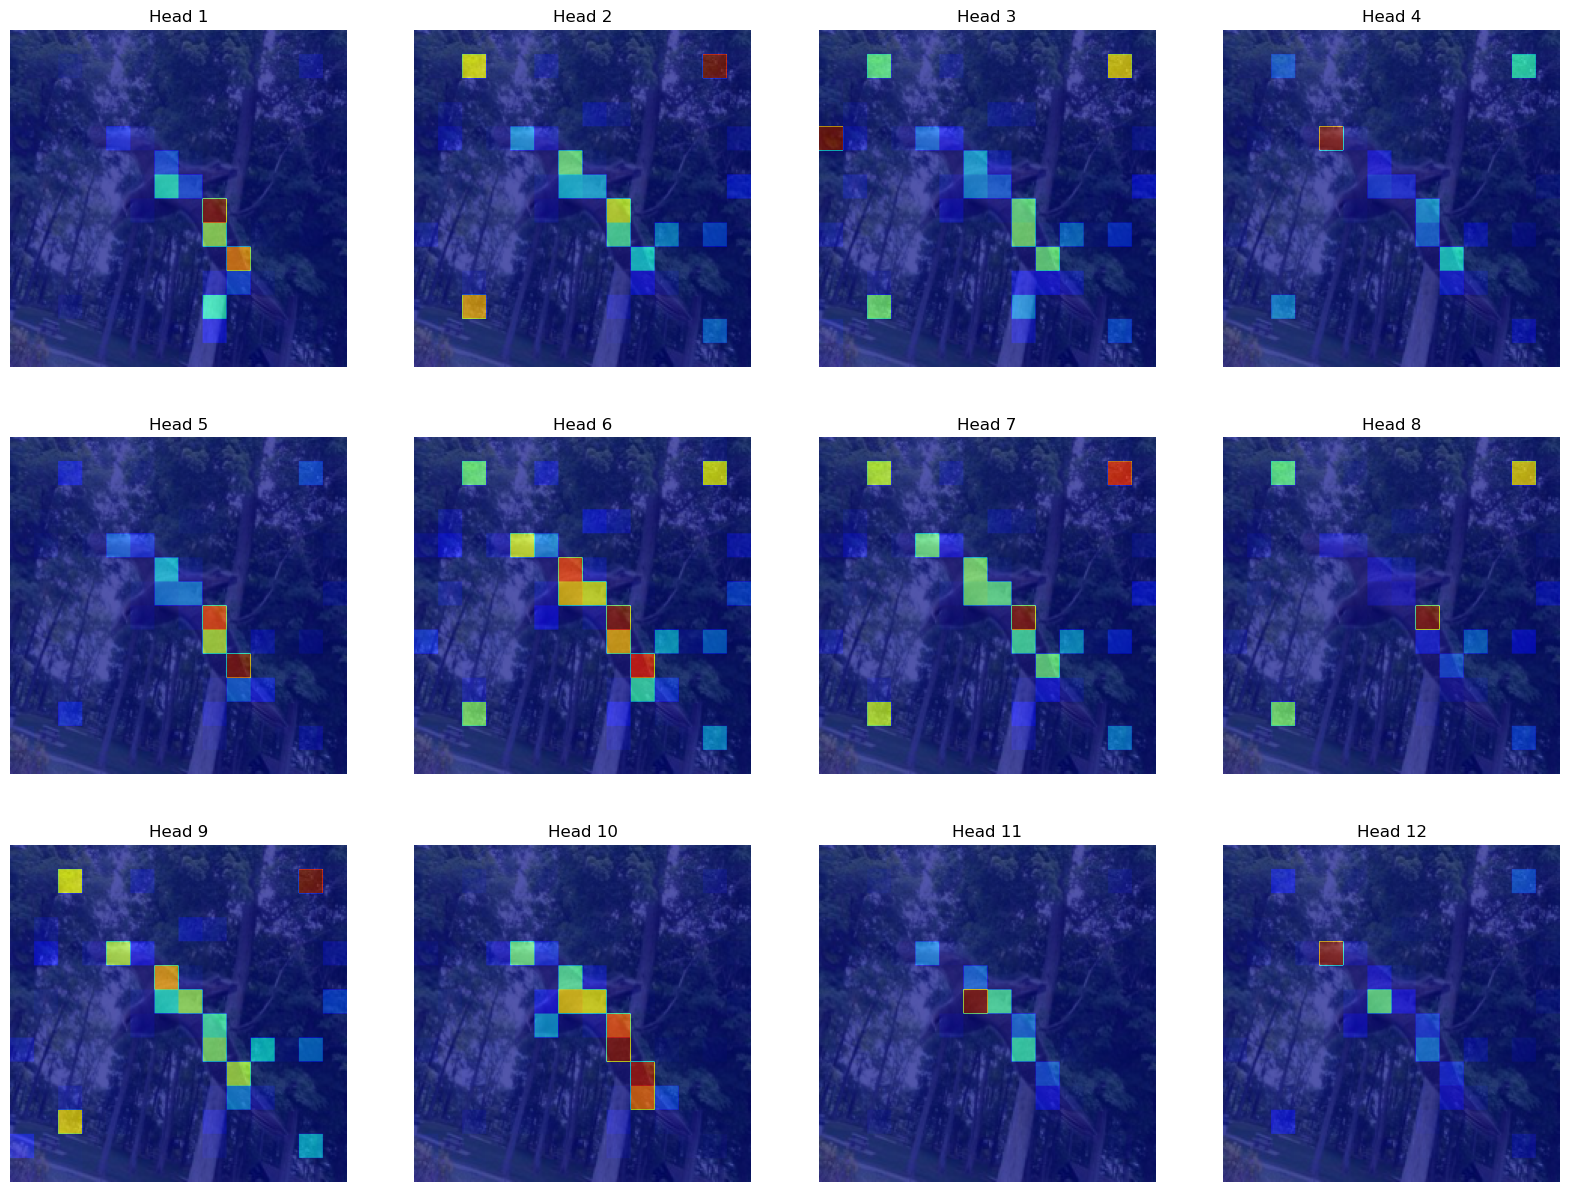

In [35]:
visualize_heatmaps(img,a_attn_w[:,:,:])

In [36]:
from modified_vit import ModifiedViT

modified_model = ModifiedViT(model)

In [37]:
with torch.no_grad():
    output_all_heads = modified_model(img.unsqueeze(0))
    cls_token_all_heads = output_all_heads[:, 0, :]

In [38]:
num_heads = model.encoder.layers[-1].self_attention.num_heads
head_effects = []

for head in range(num_heads):
    # Create head mask: 1 for all heads, except 0 for the current head
    head_mask = torch.ones(num_heads)
    head_mask[head] = 0  # Mask out the current head

    # Run the model with the current head masked out
    with torch.no_grad():
        output_masked = modified_model(img.unsqueeze(0), head_mask=head_mask)
        cls_token_masked = output_masked[:, 0, :]  # Shape: (batch_size, embed_dim)

    # Compute the difference between the baseline and masked outputs
    difference = cls_token_all_heads - cls_token_masked
    difference_norm = torch.norm(difference, p=2, dim=-1).item()  # Scalar value

    head_effects.append(difference_norm)
    print(f"Head {head + 1}: Effect on [CLS] token = {difference_norm:.4f}")


Head 1: Effect on [CLS] token = 5.7312
Head 2: Effect on [CLS] token = 4.4332
Head 3: Effect on [CLS] token = 2.9122
Head 4: Effect on [CLS] token = 4.0645
Head 5: Effect on [CLS] token = 2.5313
Head 6: Effect on [CLS] token = 2.1499
Head 7: Effect on [CLS] token = 2.7045
Head 8: Effect on [CLS] token = 4.7352
Head 9: Effect on [CLS] token = 4.1674
Head 10: Effect on [CLS] token = 6.7084
Head 11: Effect on [CLS] token = 9.6704
Head 12: Effect on [CLS] token = 3.8465
